<a href="https://colab.research.google.com/github/shanyaanand/deep-learning/blob/master/q_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

In [2]:
!pip install tensorflow==1.13.2

     |████████████████████████████████| 92.6MB 43kB/s 
     |████████████████████████████████| 51kB 6.4MB/s 
     |████████████████████████████████| 3.2MB 38.8MB/s 
     |████████████████████████████████| 368kB 37.6MB/s 
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorflow 2.3.0
    Uninstalling tensorflow-2.3.0:
      Successfully uninstalled tensorflow-2.3.0


In [3]:
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
import torch
import torch.nn as nn
import pandas as pd
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable
import calendar 
!pip install gym
!pip install stable-baselines

     |████████████████████████████████| 245kB 2.8MB/s 


In [4]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [5]:
class DQN(nn.Module):

    def __init__(self, input_size, hidden_dims, output_dims):
        """Initialize a decoder in DA_RNN."""
        super(DQN, self).__init__()
        self.hidden_dims = hidden_dims
        self.input_size = input_size
        self.output_dims = output_dims

        self.fc = nn.Sequential(
            nn.Linear(self.input_size, self.hidden_dims),
            nn.BatchNorm1d(self.hidden_dims),
            nn.ReLU(),
            nn.Linear(self.hidden_dims, 2*self.hidden_dims),
            nn.BatchNorm1d(2*self.hidden_dims),
            nn.ReLU(),
            nn.Linear(2*self.hidden_dims, 2*self.hidden_dims),
            nn.BatchNorm1d(2*self.hidden_dims),
            nn.ReLU(),
            nn.Linear(2*self.hidden_dims, self.hidden_dims),
            nn.BatchNorm1d(self.hidden_dims),
            nn.ReLU(),                        
        )
        print(self.fc)
        self.q_value = nn.Sequential(
            nn.Linear(self.hidden_dims, self.output_dims),
            nn.BatchNorm1d(self.output_dims),
            nn.Softmax(-1)
        )

    def forward(self, x):
        """forward."""      

        x = self.fc(x)
        q_Action = self.q_value(x)
        return q_Action


In [98]:
import numpy as np
import pandas as pd
from gym.utils import seeding
import gym
import csv
from gym import spaces
from datetime import datetime
import matplotlib.pyplot as plt
from datetime import datetime
from calendar import isleap
from stable_baselines.common.vec_env import DummyVecEnv, VecNormalize
# player mode - slightly mor advance with more functinality


class StockEnvPlayer(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, df, interval, mode = 'Train', logfile = './Logger.txt', modelName='q-learning', ntimestep = 20, initial_investment=100000, seed=7, commission=1.0, addTA=False):
        super(StockEnvPlayer, self).__init__()
        self.addTA = addTA
        self.interval = interval
        self.X = np.zeros([ntimestep, 8*len(interval)])
        self.mode = mode
        self.cummulativepnl = 0
        self.done = False
        self.closing_price = []
        self.bought = []
        self.sold = []
        self.df = df
        self.leg = ntimestep
        self.episode_reward = 0
        self.G = []
        self.lastsell = 0
        self.possell = 0
        self.negsell = 0
        self.lastbuy = 0 
        self.illegal = 0 
        self.action_validation = np.zeros(len(interval) + 1) # add 1 for p_t-1
        self.avg_closing = np.zeros(len(interval))
        self.ntimestep = ntimestep
        self.dates = df.date# number of samples 
        self.numSecurity = 1 # how many stock are there in a portfolio in our case two
        self.numTrainDay = len(self.df)
        self.terminal = False
        self.commission = float(commission)*-1
        self.inventory = []
        self.initial_investment = initial_investment
        self.logfile = logfile
        self.i = 0
        self.modelName = modelName
        self._seed(seed)
        date = list(self.df.date)
        year = []
        month = []
        day = []
        weekday = []
        for i in date:
          t = i.split("/")
          year.append(float(t[0]))
          month.append(float(t[1]))
          day.append(float(t[2]))
          weekday.append(self.findDay(i))
        self.df.loc[:, 'year'] = np.array(year)
        self.df.loc[:, 'month'] = np.array(month)
        self.df.loc[:, 'date'] = np.array(day)
        self.df.loc[:, 'day'] = np.array(weekday)
        self.TA_columns = ['Value(Lk)', 'Avg3(E,25,E,13,E,8)-Avg1',
       'Avg3(E,25,E,13,E,8)-Avg2', 'Avg3(E,25,E,13,E,8)-Avg3',
       'year', 'month', 'date', 'day', 'hour', 'minute', 'second']
        self.action_space = spaces.Box(
            low=0, high=2, shape=(1, ), dtype=np.float16)# change
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(ntimestep*len(self.TA_columns)+(8*len(self.interval)+3)*self.ntimestep+\
                                                                       len(self.action_validation)+len(self.avg_closing)+8, ))
        print('observation_space :\t', self.observation_space)
        print('action_space :\t', self.action_space)
        self.reset()
        print(ntimestep*len(self.TA_columns)+(8*len(self.interval)+3)*self.ntimestep+\
                                                                       len(self.action_validation)+len(self.avg_closing)+8)
        # write column header for the first time
        with open(logfile, 'a+') as f:
            ap = ['asset' + str(i) + '_price' for i in range(self.numSecurity)]
            aq = ['asset' + str(i) + '_qty' for i in range(self.numSecurity)]
            others = ['asset' + str(i) + '_' + col for i in range(self.numSecurity)
                      for col in self.TA_columns]
            column = 'model, incTA?, step, date, cash, portfolio, reward, total_commission, buy_amt, buy_commission, sell_amt, sell_commission,' + \
                ','.join(ap) + ',' + ','.join(aq) + ',' + '\n'
            f.write(column)

    def findDay(self, t): 
        year, month, day = t.split('/')     
        dayNumber = calendar.weekday(int(year), int(month), int(day)) 
        return float(dayNumber)

    def pastdata(self):
      self.X = np.zeros([self.ntimestep, 8*len(interval)])
      for t in range(len(self.interval)):
        time = self.interval[t]
        index = []
        i = self.leg - time - 1
        l = 0
        while True:
          if i < 0 or l == self.ntimestep:
            break
          else:
            self.X[l, 8*t] = (self.df.loc[i, 'Avg3(E,25,E,13,E,8)-Avg1'])
            self.X[l, 1+8*t] = (self.df.loc[i, 'year'])
            self.X[l, 2+8*t] = (self.df.loc[i, 'month'])
            self.X[l, 3+8*t] = (self.df.loc[i, 'date'])
            self.X[l, 4+8*t] = (self.df.loc[i, 'day'])
            self.X[l, 5+8*t] = (self.df.loc[i, 'hour'])
            self.X[l, 6+8*t] = (self.df.loc[i, 'minute'])
            self.X[l, 7+8*t] = (self.df.loc[i, 'second'])
            l +=1
          i-=time


    def reset(self):

        self.portfolio_value = [self.initial_investment] # check point 
        self.net_cash = [self.initial_investment]
        self.leg = self.ntimestep
        self.X = np.zeros([self.ntimestep, 8*len(interval)])
        self.ledger = []
        self.lastsell = 0
        self.possell = 0
        self.negsell = 0
        self.lastbuy = 0 
        self.illegal = 0
        self.action_validation = np.zeros(len(interval) + 1) # add 1 for p_t-1
        self.avg_closing = np.zeros(len(interval))        
        self.i = 0
        self.terminal = False
        self.done = False
        self.reward = 0
        self.df.loc[:, 'qty'] = 0.0
        self.df.loc[:self.ntimestep, 'initial'] = self.initial_investment ###check
        self.commission_paid = [0] * len(self.dates)
        self.transaction = {"buy_amt": 0, "buy_commission": 0,
                            "sell_amt": 0, "sell_commission": 0, }

        # return as range of one day else it becomes a panda series
        self.data = self.df[self.leg-self.ntimestep:self.leg]
        self.value = self.data.loc[:, ['initial']].values# initial investment
        self.price = self.data.loc[:, ['Close']].values
        self.qty = self.data.loc[:, ['qty']].values
        self.ta = self.data.loc[:, self.TA_columns].values.reshape(-1, 1)
        self.state = np.array(list(self.avg_closing)+ list(self.price)+ list(self.ta)+ list(self.X.reshape(-1,1))+ [1]+ list(self.value)+ list(self.qty)+
                                     list(self.action_validation)+ [self.lastsell, self.possell, self.negsell, self.lastbuy, self.cummulativepnl, self.illegal, 0])

        return np.squeeze(self.state)

    def _sell_stock(self):
        if self.qty[-1] > 0:
            self.lastsell = 0
            self.sold.append(self.i)
            # quantity = min(abs(action), self.qty[index])
            quantity = 1.0
            sell_amt = self.price[-1] * quantity
            self.transaction["sell_amt"] += sell_amt
            self.transaction["sell_commission"] += sell_amt * self.commission
            self.commission_paid[self.leg] += sell_amt * self.commission
            self.value[:-1] = self.value[1:]
            self.value[-1]+= sell_amt + (self.commission)
            self.qty[:-1] = self.qty[1:]
            self.qty[-1] -= quantity
            if self.qty[-1] == 0.0:
              self.done = True
              self.G.append(self.episode_reward)
              self.episode_reward = 0
            # update investment and qty
            self.state = np.concatenate((self.value, self.price, self.qty, self.ta, self.X.reshape(-1,1)))

        else:
            self.illegal = 1
            self.lastsell += 1
            self.dont = True
            self.episode_reward -= 10
            self.reward = -10
            # print("No asset to sell")
            pass

    def _buy_stock(self):
        min_quantity = self.value[-1] // self.price[-1] # max qauntity which can be purchased
        quantity = min(min_quantity, 1.0)
        if quantity > 0:
          self.lastbuy = 0
          # print("Bought at price {}".format(self.price[-1]))
          self.bought.append(self.i)
          buy_amt = self.price[-1] * quantity
          # print("buy", self.dates[self.day], index, action, quantity)
          self.inventory.append(buy_amt)
          self.transaction["buy_amt"] += buy_amt
          self.transaction["buy_commission"] += buy_amt * self.commission

          self.commission_paid[self.leg] += buy_amt * self.commission
          self.value[:-1] = self.value[1:]
          self.value[-1] -= (buy_amt - (self.commission))# check point; check for proper buying commission

          self.qty[:-1] = self.qty[1:]
          self.qty[-1] += quantity
          # update investment and qty
          self.state = np.concatenate((self.value, self.price, self.qty, self.ta, self.X.reshape(-1,1)))


        else:
          self.illegal = 1
          self.lastbuy += 1
          self.dont = True
          self.episode_reward -= 10
          # print("No cash to buy")
          self.reward = -10
          pass

    def step(self, actions):
        self.illegal = 0
        self.dont = False
        self.done = False
        self.terminal = self.leg >= (self.numTrainDay-1)
        self.transaction = {"buy_amt": 0, "buy_commission": 0,
                            "sell_amt": 0, "sell_commission": 0, }# check point

        if self.terminal:
            print("**** Summary*****")
            print("Model:\t\t\t", self.modelName.upper())
            print("Number of Assets:\t{:8.0f}".format(self.numSecurity))
            print("Initial Investment :\t{:8.2f}".format(self.initial_investment))
            portfolio_value = self.value[-1] + (self.price[-1] * self.qty[-1])
            rtns_dollar = np.round(portfolio_value[0] - self.initial_investment, 2)
            rtns_pct = np.round((portfolio_value[0]/self.initial_investment-1)*100, 2)
            # rtns_annualised = (1+rtns_pct) ** (1/self.years)-1
            print("Portfolio Value:\t{:8.2f}".format(portfolio_value[0]))
            print("% Returns:\t\t{:8.2f}%".format(rtns_pct))
            print("***************")
            # fig, ax = plt.subplots()
            # ax.set_title(self.modelName)
            # ax.set_ylabel('Total Asset $')
            # ax.set_xlabel('Episode')
            # ax.plot(self.portfolio_value, color='tomato')
            # plt.savefig('image/{}.png'.format(self.modelName))
            # plt.close()
            with open(self.logfile, 'a+') as myfile:
                wr = csv.writer(myfile)
                wr.writerows(self.ledger)
            print("Terminal state reseting the environment")
            self.render()
        else:
            begin_total_asset = self.value[-1] + (self.price[-1] * self.qty[-1])
            begin_cash = self.value[-1]
            self.closing_price.append(self.price[-1])
            """
              Action 0 : buy
              Action 1 : hold
              Action 2 : sell
            """
            if actions == 2:
              self.lastbuy+=1
              self._sell_stock()
            elif actions == 1:
              self.lastsell += 1
              self.possell += 1
              self.negsell += 1
              self._buy_stock()       
            else:
              self.lastsell += 1
              self.possell += 1
              self.negsell += 1
              self.lastbuy += 1
              self.value[:-1] = self.value[1:]
              self.value[-1] = self.value[-1]
              self.qty[:-1] = self.qty[1:]
              self.qty[-1] = self.qty[-1]
              
            # get next day's price & ta
            self.leg += 1
            self.i+=1
            self.data = self.df[self.leg - self.ntimestep:self.leg]
            self.price = self.data.loc[:, ['Close']].values
            self.ta = self.data.loc[:, self.TA_columns].values.reshape(-1, 1)           
            self.pastdata()
            self.lastmovevalidation(actions)
            end_total_asset = self.value[-1] + (self.price[-1] * self.qty[-1])
            self.episode_reward +=(end_total_asset - begin_total_asset)[0]
            self.cummulativepnl += (end_total_asset - begin_total_asset)[0]
            if not self.dont:            
              self.reward = (end_total_asset - begin_total_asset)[0]         
              if actions == 2:
                if self.reward > 2:
                  self.possell = 0
                  self.negsell += 1
                else:
                  self.possell += 1
                  self.negsell = 0
            else:
              self.value[:-1] = self.value[1:]
              self.value[-1] = self.value[-1]
              self.qty[:-1] = self.qty[1:]
              self.qty[-1] = self.qty[-1]     
            self.state = np.array(list(self.avg_closing)+ list(self.price)+ list(self.ta)+ list(self.X.reshape(-1,1))+ [1]+ list(self.value)+ list(self.qty)+
                                     list(self.action_validation)+ [self.lastsell, self.possell, self.negsell, self.lastbuy, self.cummulativepnl, self.illegal, 0])
            self.portfolio_value.append((end_total_asset))
            self.G.append((end_total_asset - begin_total_asset)[0])
        return np.squeeze(self.state).copy(), self.reward, self.terminal, {}

    def lastmovevalidation(self, actions):
      """
        check how good was the last move based on mean closing values
        assuming increment in self.leg has been done !!!
      """
      for i in range(len(self.interval)):
        mean_price = np.mean(self.df.Close[self.leg - self.interval[i]: self.leg])
        self.avg_closing[i] = mean_price

      if actions == 0:
        self.action_validation[0] = 1 if abs(self.df.Close[self.leg] - self.df.Close[self.leg - 1]) <= 2 else 0 
      elif actions == 1:# buy
        self.action_validation[0] = 1 if self.df.Close[self.leg - 1] > self.df.Close[self.leg] - 2 else 0 
        for i in range(len(self.interval)):
          mean_price = np.mean(self.df.Close[self.leg - self.interval[i]: self.leg])
          self.action_validation[i+1] = 1 if mean_price > self.df.Close[self.leg] - 2else 0
      else:# sell
        self.action_validation[0] = 1 if self.df.Close[self.leg] > self.df.Close[self.leg - 1] - 2 else 0 
        for i in range(len(self.interval)):
          mean_price = np.mean(self.df.Close[self.leg - self.interval[i]: self.leg])
          self.action_validation[i+1] = 1 if mean_price - 2 < self.df.Close[self.leg] else 0

    def render(self, mode='human'):
        line = np.array([self.modelName, self.addTA, self.leg, str(self.dates[self.leg]), str(
            self.value[-1]), str(self.portfolio_value[-1]), self.reward,
            self.commission_paid[self.leg-1],
            self.transaction["buy_amt"], self.transaction["buy_commission"],
            self.transaction["sell_amt"], self.transaction["sell_commission"]
        ])
        display = np.concatenate((line, self.price[-1], self.qty[-1]))
        self.ledger.append(display)
        fig, ax = plt.subplots()
        ax.set_title(self.modelName)
        ax.set_ylabel('Total Asset $')
        ax.set_xlabel('Episode')
        ax.plot(self.portfolio_value, color='tomato')
        fig = plt.figure(figsize = (15,5))
        plt.plot(self.closing_price, color='gold', lw=2.)
        plt.plot(self.closing_price, '*', markersize=6, color='r', label = 'buying signal', markevery = self.bought)
        plt.plot(self.closing_price, 'o', markersize=6, color='g', label = 'selling signal', markevery = self.sold)
        plt.title('{} reward {} total capital {} # buying {} # selling {}'.format(self.mode, self.episode_reward, self.value[-1], len(self.bought), len(self.sold)))
        plt.legend()
        plt.show()
        self.i = 0
        self.closing_price = []
        self.bought = []
        self.sold = []
        self.episode_reward = 0
    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

In [9]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    policy_net.train()
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch.float()).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states.float()).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values.unsqueeze(1) * GAMMA) + reward_batch
    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values.float(), expected_state_action_values.float())

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()


    # for param in policy_net.parameters():
    #     print(param.grad.size())
    #     print(param.grad)
    #     # param.grad.data.clamp_(-1, 1)

    optimizer.step()

In [100]:
BATCH_SIZE = 256
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.1
EPS_DECAY = 400
TARGET_UPDATE = 50000
n_actions = 3
T = 20
interval = [2, 3, 6, 12, 16, 18]
memory = ReplayMemory(20000)
# Get screen size so that we can initialize layers correctly based on shape
# returned from AI gym. Typical dimensions at this point are close to 3x40x90
# which is the result of a clamped and down-scaled render buffer in get_screen()
train = pd.read_csv("./train10min.csv")
train_env = DummyVecEnv(
    [lambda: StockEnvPlayer(train, interval)])

# Automatically normalize the input features
train_env = VecNormalize(train_env, norm_obs=True, norm_reward=False, clip_obs=10.)
test = pd.read_csv("./test10min.csv")
test_env = DummyVecEnv(
    [lambda: StockEnvPlayer(test, interval, mode='Test')])

# Automatically normalize the input features
test_env = VecNormalize(test_env, norm_obs=True, norm_reward=False, clip_obs=10.)

state = train_env.reset()
input_size = (state).shape[-1]
print(input_size)
policy_net = DQN(input_size, 1028, n_actions).to(device)
target_net = DQN(input_size, 1028, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
decayRate = 0.5
lr = 0.001
# optimizer = optim.RMSprop(policy_net.parameters())
optimizer = torch.optim.Adam(params=policy_net.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)
steps_done = 0

def select_action(state, mode = 'train'):
    global steps_done
    policy_net.eval()
    if mode == 'train':
      sample = random.random()
      eps_threshold = EPS_END + (EPS_START - EPS_END) * \
          math.exp(-1. * steps_done / EPS_DECAY)
      steps_done += 1

      if sample > eps_threshold:
          with torch.no_grad():
              # t.max(1) will return largest column value of each row.
              # second column on max result is index of where max element was
              # found, so we pick action with the larger expected reward.
              return policy_net(state.float()).max(1)[1].view(1, 1)
      else:
          return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)
    else:
      with torch.no_grad():
        return policy_net(state.float()).max(1)[1].view(1, 1)

observation_space :	 Box(1261,)
action_space :	 Box(1,)
1261
observation_space :	 Box(1261,)
action_space :	 Box(1,)
1261
1261
Sequential(
  (0): Linear(in_features=1261, out_features=1028, bias=True)
  (1): BatchNorm1d(1028, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Linear(in_features=1028, out_features=2056, bias=True)
  (4): BatchNorm1d(2056, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Linear(in_features=2056, out_features=2056, bias=True)
  (7): BatchNorm1d(2056, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): Linear(in_features=2056, out_features=1028, bias=True)
  (10): BatchNorm1d(1028, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
)
Sequential(
  (0): Linear(in_features=1261, out_features=1028, bias=True)
  (1): BatchNorm1d(1028, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Linear(in_fea

In [85]:
def test_run():

  ok = True
  j = 0
  total_reward = 0
  state = test_env.reset()
  while ok:     
    state = torch.from_numpy(state).to(device)
    action = select_action(state, mode="test")
    next_state, reward, terminate, info = test_env.step(action)
    state = next_state
    total_reward+=reward 
    j+=1
    if terminate:
      ok = False
      break            
  print("test", total_reward[0])


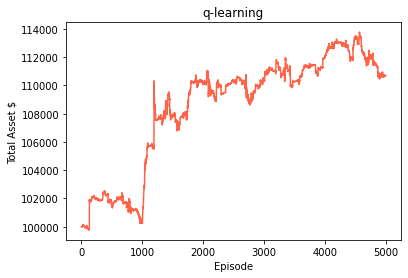

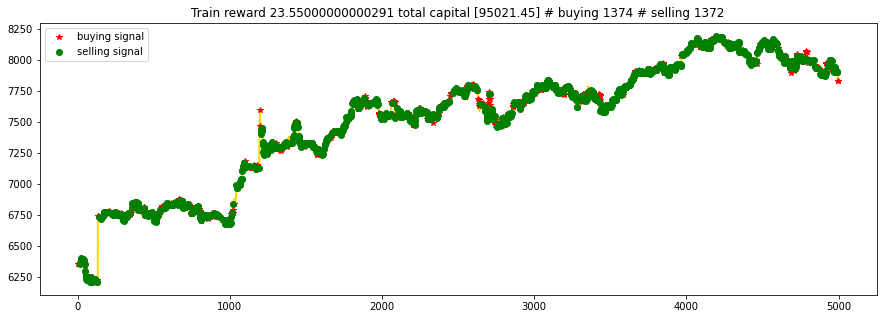

**** Summary*****
Model:			 Q-LEARNING
Number of Assets:	       1
Initial Investment :	100000.00
Portfolio Value:	114049.75
% Returns:		   14.05%
***************
Terminal state reseting the environment


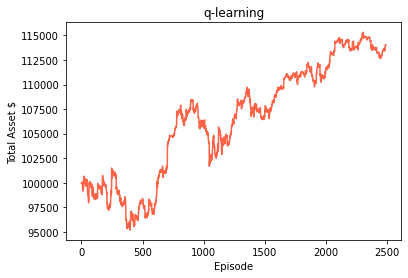

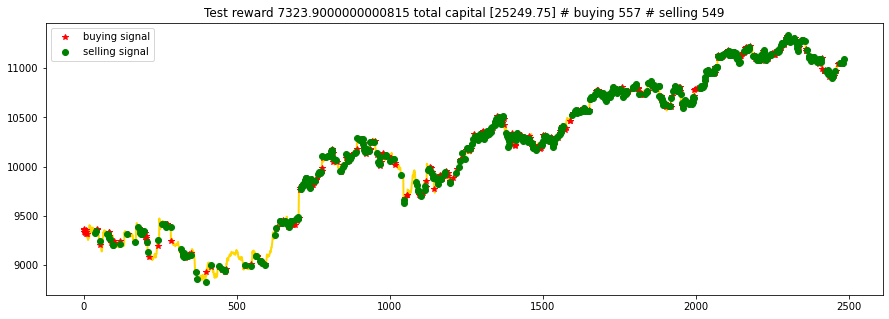

test -3796.0493


In [ ]:
max_episode = 50
# Initialize the environment and state

for n_episode in range(max_episode):
  state = train_env.reset()  
  state = torch.from_numpy(state).to(device)  
  timestep = 0
  while True:
    if timestep % TARGET_UPDATE == 0:
      target_net.load_state_dict(policy_net.state_dict())        
    # Select and perform an action
    timestep+=1

    action = select_action(state)
    next_state, reward, done, info = train_env.step(action)
    next_state = torch.from_numpy(next_state).to(device)  
    reward = torch.tensor([reward], device=device)

    if done:
      temp = next_state
      next_state = None
    # Store the transition in memory
    memory.push(state, action, next_state, reward)      
    if done:
      state = temp
    else:
      state = next_state

    # Perform one step of the optimization (on the target network)
    optimize_model()
    if done:
      break
    if timestep%5000 == 0:

      lr_scheduler.step()
      train_env.render()
      test_run()   
      
